In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False

In [2]:
dim = 3
corr = 0.

beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [7]:
n_var = 10000
n_perms = None

n_boot = 500
n_run = 100

n_n_outer = 30
min_n_outer = 20
max_n_outer = 2000

all_n_outer = np.logspace(np.log10(min_n_outer), np.log10(max_n_outer), n_n_outer, base=10, dtype=int)
assert len(np.unique(all_n_outer)) == n_n_outer,\
    "Wrong number of all_No %d != %d" % (len(np.unique(all_n_outer)), n_n_outer)
    
all_n_inner = [2, 5, 10]
n_n_inner = len(all_n_inner)
method = 'exact' if n_perms is None else 'random'

In [4]:
%%time

all_shapley_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_outer, n_n_inner, n_run, dim, n_boot))

for i_outer, n_outer in enumerate(all_n_outer):
    for i_inner, n_inner in enumerate(all_n_inner):
        print('No:', n_outer, 'Ni:', n_inner)
        for i_run in range(n_run):
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_outer, i_inner, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_outer, i_inner, i_run] = shapley_results.full_first_indices
            all_total_results[i_outer, i_inner, i_run] = shapley_results.full_total_indices

No: 20 Ni: 2
No: 20 Ni: 5
No: 20 Ni: 10
No: 100 Ni: 2
No: 100 Ni: 5
No: 100 Ni: 10
No: 499 Ni: 2
No: 499 Ni: 5
No: 499 Ni: 10
CPU times: user 3min 16s, sys: 1min 24s, total: 4min 40s
Wall time: 1min 49s


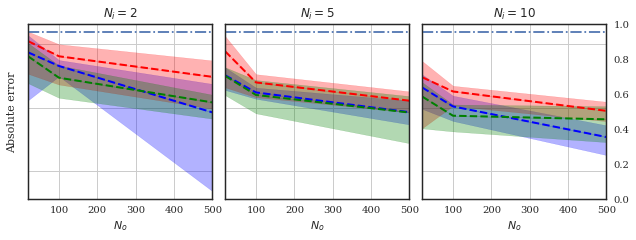

In [6]:
# Coverage probability
ci_prob = 0.05
error_type = 'absolute'
logscale = True
name = 'N_o'

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_outer
    name_axes = 'N_o'
    axis = 0
else:
    x_ticks = all_n_outer
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)
if n_col > 3:
    assert n_col == 6, "Only works with n=6"
    fig, axes = plt.subplots(2, int(n_col/2), figsize=(2*3+3, 6), sharex=True, sharey=True)
    lvl = 2
else:
    fig, axes = plt.subplots(1, n_col, figsize=(2*n_col+3, 3.5), sharex=True, sharey=True) 
    lvl = 1
    
axes = [axes] if n_col == 1 else axes

legend = False
for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Chose the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
    if i_ax == n_col-1:
        legend = True
    
    plot_error(results, true_results, x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)
    
    ax_cover = ax_err.twinx()
    #plot_cover(results, true_results, x_ticks, ax=ax_cover, ci_prob=ci_prob)
        
    ax_cover.set_ylim(0., None)
        
    if lvl == 1:
        ax_err.set_xlabel('$%s$' % (name))
            
        if i_ax > 0:
            ax_err.set_ylabel('')
            ax_err.set_yticklabels([])
            
        if i_ax < n_col - 1:
            ax_cover.set_ylabel('')
            ax_cover.set_yticks([])
            
    else:
        if i_ax != 2 and i_ax != n_col-1:
            ax_cover.set_ylabel('')
        if i_ax != 0 and i_ax != 3:
            ax_err.set_ylabel('')
        if 2 < i_ax <= n_col-1:
            ax_err.set_xlabel('$%s$' % (name))
        else:
            ax_err.set_xlabel('') 
        
    ax_cover.plot(ax_err.get_xlim(), [1. - ci_prob]*2, '-.')
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    ax_err.grid()
fig.tight_layout()
if savefigs:
    name = './output/gaussian_precision_nNo_%d_nNi_%d_rho_%.2f_Nv_%d_maxNo_%d_maxNi_%d_nrun%d_absolute%d.pdf' %\
        (n_No, n_Ni, corr, Nv, max_No, max_Ni, n_run, absolute_error)
    fig.savefig(name)